# Simple properties of the learners: do they find the correct constant policies?

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import pandas as pd
import torch

import wandb

## Step 1: finding a parameter range that explores different policies


In [4]:
%run groundTruth.py

Text(0, 0.5, 'Optimal action')

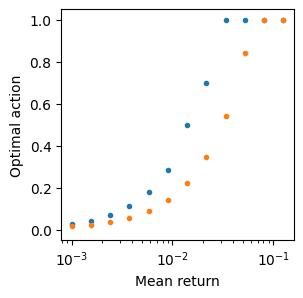

In [78]:
mus = np.logspace(-3, -0.9, 12)
actions_sqrt = []
actions_log = []

figsize(3,3)

for mu in mus:
    actions_sqrt.append( findBestAction_determ(mu, 0.25, 1., np.sqrt).x[0] )
    actions_log.append( findBestAction_determ(mu, 0.25, 1., np.log).x[0] )
    
plt.semilogx(mus, actions_sqrt, '.')
plt.semilogx(mus, actions_log, '.')
plt.ylim([-0.05, 1.05])
plt.xlabel('Mean return')
plt.ylabel('Optimal action')

### This is a nice range of means that allows both utility functions to explore a range of optimal allocations

Text(0, 0.5, 'Optimal action')

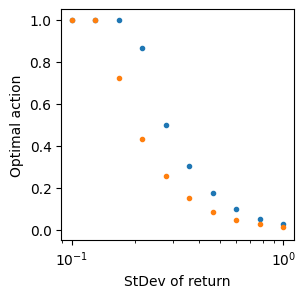

In [79]:
sigmas = np.logspace(-1, 0., 10)
actions_sqrt = []
actions_log = []

figsize(3,3)

for sigma in sigmas:
    actions_sqrt.append( findBestAction_determ(0.02, sigma, 1., np.sqrt).x[0] )
    actions_log.append( findBestAction_determ(0.02, sigma, 1., np.log).x[0] )
    
plt.semilogx(sigmas, actions_sqrt, '.')
plt.semilogx(sigmas, actions_log, '.')
plt.ylim([-0.05, 1.05])
plt.xlabel('StDev of return')
plt.ylabel('Optimal action')

### This is a good range of standard deviations.

## Step 2: Double checking these ground truth solutions against numerical sampling

The sampler uses the same statistics as the learners. Double checking consistency here.

In [ ]:
# this is slow, but its worth double checking

from scipy.stats import ttest_1samp

muDifferences = pd.DataFrame(columns=['mu', 'util', 'p', 'diff'])
sigmaDifferences = pd.DataFrame(columns=['sigma', 'util', 'p', 'diff'])


for mu in mus:
    for utilityFn in [np.sqrt, np.log]:
        baseline = findBestAction_determ(mu, 0.25, 1., utilityFn).x[0]
        samples = []
        for sampleN in range(200):
            samples.append( findBestAction(mu, 0.25, 1., utilityFn).x[0] )

        print('m', mu)
        P = ttest_1samp(samples, baseline).pvalue
        diff = np.mean(samples) - baseline
        row = pd.DataFrame([{'mu': mu,'util':str(utilityFn),'p': P,'diff': diff}])
        muDifferences = pd.concat( [muDifferences, row], ignore_index=True)
        

for sigma in sigmas:
    for utilityFn in [np.sqrt, np.log]:
        baseline = findBestAction_determ(0.02, sigma, 1., utilityFn).x[0]
        samples = []
        for sampleN in range(200):
            samples.append( findBestAction(0.02, sigma, 1., utilityFn).x[0] )

        print('s', sigma)
        P = ttest_1samp(samples, baseline).pvalue
        diff = np.mean(samples) - baseline
        row = pd.DataFrame([{'sigma':sigma,'util':str(utilityFn), 'p': P, 'diff': diff}])
        sigmaDifferences = pd.concat( [sigmaDifferences, row], ignore_index=True)
        

In [155]:
muDifferences

,mu,util,p,diff
0,0.001000,<ufunc 'sqrt'>,2.953693e-09,4.891647e-03
1,0.001000,<ufunc 'log'>,3.664106e-02,-8.678654e-04
2,0.001552,<ufunc 'sqrt'>,9.424027e-08,4.664907e-03
3,0.001552,<ufunc 'log'>,1.484969e-01,-5.352116e-04
4,0.002409,<ufunc 'sqrt'>,5.581269e-04,3.049392e-03
5,0.002409,<ufunc 'log'>,3.246900e-01,-4.261821e-04
6,0.003739,<ufunc 'sqrt'>,1.511952e-08,4.609161e-03
7,0.003739,<ufunc 'log'>,1.662824e-23,4.541669e-03
8,0.005803,<ufunc 'sqrt'>,3.727911e-02,1.792862e-03
9,0.005803,<ufunc 'log'>,3.009851e-16,3.518838e-03


In [144]:
sigmaDifferences

,sigma,util,p,diff
0,0.100000,<ufunc 'sqrt'>,1.754497e-01,1.347948e-10
1,0.100000,<ufunc 'log'>,1.234404e-02,-1.931788e-13
2,0.129155,<ufunc 'sqrt'>,2.602750e-02,-1.938449e-13
3,0.129155,<ufunc 'log'>,1.704846e-04,-3.885781e-15
4,0.166810,<ufunc 'sqrt'>,8.818402e-02,-7.993606e-15
5,0.166810,<ufunc 'log'>,8.567265e-01,1.166584e-04
6,0.215443,<ufunc 'sqrt'>,6.106401e-02,-1.673284e-03
7,0.215443,<ufunc 'log'>,5.022880e-01,3.323196e-04
8,0.278256,<ufunc 'sqrt'>,3.209623e-54,1.631573e-02
9,0.278256,<ufunc 'log'>,5.088905e-05,1.539331e-03


### Ok, this is not quite as clear of a signal as I was hoping for. 

Many of the results are, in fact, not significantly different, as you would hope. However, there are quite a few that are significantly different. 

 - Of course, we are doing a lot of tests, so it is quite likely that some of the sampled p-values would be small.
 
 - It's also possible that the noise is non-Gaussian, impacting the test: it comes out of a maximization process, and the results are limited to the range [0,1] 
 
How to proceed?

 - Many of the differences, while significant, are small. In some sense, this sets a bound on the accuracy that we can expect from the learners.

### looking into the biggest differences

In [231]:
muDifferences[ (muDifferences['diff'].abs() > 1E-3) & ((muDifferences.p) < 1E-3 )]

,mu,util,p,diff
0,0.001000,<ufunc 'sqrt'>,2.953693e-09,0.004892
2,0.001552,<ufunc 'sqrt'>,9.424027e-08,0.004665
4,0.002409,<ufunc 'sqrt'>,5.581269e-04,0.003049
6,0.003739,<ufunc 'sqrt'>,1.511952e-08,0.004609
7,0.003739,<ufunc 'log'>,1.662824e-23,0.004542
9,0.005803,<ufunc 'log'>,3.009851e-16,0.003519
12,0.013978,<ufunc 'sqrt'>,8.905024e-143,-0.052963
13,0.013978,<ufunc 'log'>,6.462781e-04,0.001383
19,0.052261,<ufunc 'log'>,1.397101e-04,-0.001645


In [232]:

sigmaDifferences[ (sigmaDifferences['diff'].abs() > 1E-3) & (sigmaDifferences['p'] < 1E-3) ]

,sigma,util,p,diff
8,0.278256,<ufunc 'sqrt'>,3.209623e-54,0.016316
9,0.278256,<ufunc 'log'>,5.088905e-05,0.001539
14,0.599484,<ufunc 'sqrt'>,6.193540e-12,-0.002397
17,0.774264,<ufunc 'log'>,5.746340e-18,0.148908
19,1.000000,<ufunc 'log'>,8.743681e-48,0.319038


### Examples:

In [246]:
#1
mu = 0.013978
print('determ: ', findBestAction_determ(mu, 0.25, 1., np.sqrt).x[0] )
print('sampled: ', findBestAction(mu, 0.25, 1., np.sqrt).x[0] )

determ:  0.5
sampled:  0.43921456507622453


In this case, the deterministic optimizer appears to have failed, defaulting to the initial guess of 0.5

In [249]:
# 2
mu = 0.003739
print('determ: ', findBestAction_determ(mu, 0.25, 1., np.log).x[0] )
print('sampled: ', findBestAction(mu, 0.25, 1., np.log).x[0] )

determ:  0.05443446303651717
sampled:  0.05943453148101547


I'm not sure about what happened here. 

In [252]:
# 3
sigma = 1.000000
print('determ: ', findBestAction_determ(0.02, sigma, 1., np.log).x[0] )
print('sampled: ', findBestAction(0.02, sigma, 1., np.log).x[0] )

determ:  0.01266463038128612
sampled:  0.5


Here, the optimizer failed in the reverse direction, for the sampled condition (at least some fraction of the time)

In [253]:
# 4
sigma = 0.774264
print('determ: ', findBestAction_determ(0.02, sigma, 1., np.log).x[0] )
print('sampled: ', findBestAction(0.02, sigma, 1., np.log).x[0] )

determ:  0.025983048799755992
sampled:  0.5


Same

In [257]:
# 5
sigma = 0.278256
print('determ: ', findBestAction_determ(0.02, sigma, 1., np.log).x[0] )
print('sampled: ', findBestAction(0.02, sigma, 1., np.log).x[0] )

determ:  0.2539903784894446
sampled:  0.25624318439353466


Another example that is not easy to explain.

## Step 3: Moving on to the training

These are important caveats to keep in mind. Especially the failure mode of the ground truth, but also the level of closeness that we can demand of the ground truth solution.

In [261]:
import glob
from agents import PolicyLearning

checkpointFileNames = glob.glob('lightning_logs/dynamicSweep_mean*/*')

models = [PolicyLearning.load_from_checkpoint(ckpFile) for ckpFile in checkpointFileNames]

Text(0.5, 1.0, 'Wealth = 100')

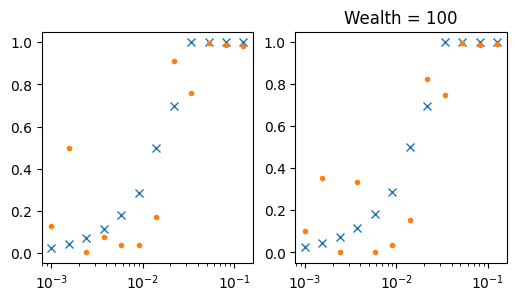

In [346]:
import torch
mus = []
theory = []
learned1 = []
learned10 = []



for model in models:
    mus.append( model.hparams.mu )
    theory.append(  findBestAction_determ(model.hparams.mu, model.hparams.sigma, 1., np.sqrt).x[0] )
    learned1.append( model.actionStatistics( torch.tensor([0.5, 0.5, 9.]))[0].item() )
    learned10.append( model.actionStatistics( torch.tensor([50., 50., 9.]))[0].item() )

figsize(6, 3)    
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.semilogx(mus, theory, 'x')
plt.semilogx(mus, learned1, '.')

plt.subplot(1,2,2)
plt.semilogx(mus, theory, 'x')
plt.semilogx(mus, learned10, '.')
plt.title('Wealth = 100')

### Some observations from this experiment

1. First of all, the results aren't great, but they do show some of the right trend.

2. The learned solutions show a strong attraction to 0 or 1, with most of the results seemingly randomly scattered around these values. In the first plot, there is even a 0.5 case, solution for one of the small mus, indicating that this failure mode is present here.

Text(0.5, 1.0, 'Allocation effect - high wealth')

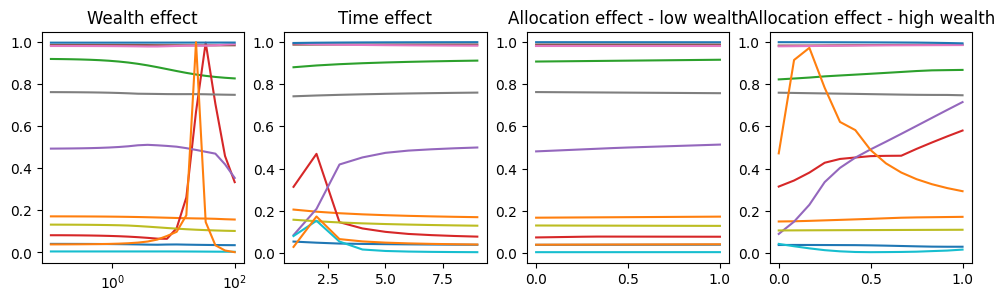

In [347]:
figsize(12,3)
plt.subplots(1, 4)

plt.subplot(1,4,1)
wealths = np.logspace(-1, 2, 20)
for model in models:
    results = []
    for wealth in wealths:
        results.append( model.actionStatistics( torch.tensor([wealth*0.5, wealth*0.5, 9.], dtype=torch.float))[0].item()  )
    plt.semilogx(wealths, results)

plt.title('Wealth effect')


plt.subplot(1,4,2)
times = np.linspace(1., 9, 9)
for model in models:
    results = []
    for time in times:
        results.append( model.actionStatistics( torch.tensor([0.5, 0.5, time], dtype=torch.float))[0].item()  )
    plt.plot(times, results)

plt.title('Time effect')


plt.subplot(1,4,3)
allocations = np.linspace(0., 1, 13)
for model in models:
    results = []
    for allocation in allocations:
        results.append( model.actionStatistics( torch.tensor([1*allocation, 1*(1-allocation), 9.], dtype=torch.float))[0].item()  )
    plt.plot(allocations, results)

plt.title('Allocation effect - low wealth')

plt.subplot(1,4,4)
allocations = np.linspace(0., 1, 13)
for model in models:
    results = []
    for allocation in allocations:
        results.append( model.actionStatistics( torch.tensor([20*allocation, 20*(1-allocation), 9.], dtype=torch.float))[0].item()  )
    plt.plot(allocations, results)

plt.title('Allocation effect - high wealth')

These learned effects are very difficult to get much out of. Some show drastic effects, while others differ little. Red, orange, purple, and blue, in particular show the biggest effect.

- One thing that we can conclude is that _high wealth_ seems to be a problem: the networks probably haven't seen much of this scenario, and fail to generalize here.


### Need to improve the learners.

Starting by simplifying them to learn constant policies. Constraining the possible policies that can be learned should make the learning task easier. Does this help?




## Constant learner

Text(0.5, 1.0, 'Learned Confidence')

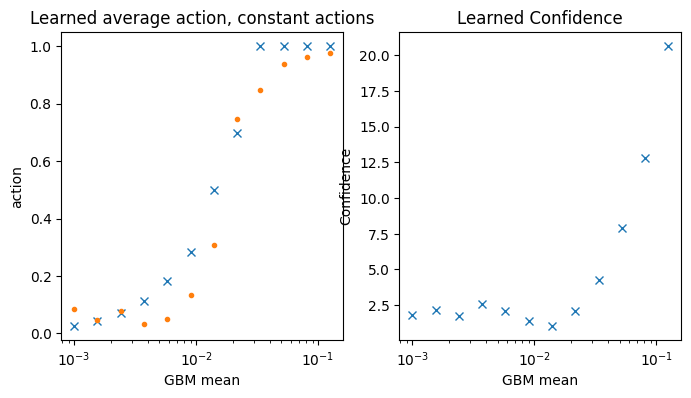

In [22]:
import glob
from agents import ConstantLearner
checkpointFileNames = glob.glob('lightning_logs/constantLearnerSweep/*/*')

models = [ConstantLearner.load_from_checkpoint(ckpFile) for ckpFile in checkpointFileNames]

mus = []
theory = []
learned = []
confidence = []

for model in models:
    mus.append( model.hparams.mu )
    theory.append(  findBestAction_determ(model.hparams.mu, model.hparams.sigma, 1., np.sqrt).x[0] )
    learned.append( model.actionStatistics( torch.tensor([0.5, 0.5, 9.]))[0].item() )
    confidence.append( model.forward( torch.tensor([0.5, 0.5, 9.])).sum().item() )

figsize(8, 4)
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.semilogx(mus, theory, 'x')
plt.semilogx(mus, learned, '.')
plt.xlabel('GBM mean')
plt.ylabel('action')
plt.title('Learned average action, constant actions')

plt.subplot(1,2,2)
plt.semilogx(mus, confidence,'x')
plt.xlabel('GBM mean')
plt.ylabel('Confidence')
plt.title('Learned Confidence')


The learned policies are ok. The mean tracks the ground truth reasonably well. However, considering how easy the learning task is, I would like to see better performance.

Also, the confidence (that is to say, the sum of the two parameters) doesn't increase as much as I would like, keeping the policy pretty stochastic. 

Some ideas for improvement
1. simply train for longer

2. change the stochastic policy

3. parameterize directly with a proportion and confidence

4. give the learners a stronger signal
    - use a parameter range with a greater range of expected utilities
    - simply multiply the utility by a large number to create greater linear differences


## Exploring other parameter ranges

/Users/luke/Documents/researchProjects/portfolioRL/groundTruth.py:37: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return -quad(toIntegrate, 0., np.inf)[0]  # negative to minimize
/Users/luke/Documents/researchProjects/portfolioRL/groundTruth.py:37: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return -quad(toIntegrate, 0., np.inf)[0]  # negative to minimize


Text(0, 0.5, 'Optimal action')

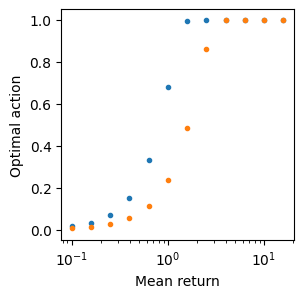

In [6]:
mus = np.logspace(-1, 1.2, 12)
actions_sqrt = []
actions_log = []

figsize(3,3)

for mu in mus:
    actions_sqrt.append( findBestAction_determ(mu, 1.8, 1., np.sqrt).x[0] )
    actions_log.append( findBestAction_determ(mu, 1.8, 1., np.log).x[0] )
    
plt.semilogx(mus, actions_sqrt, '.')
plt.semilogx(mus, actions_log, '.')
plt.ylim([-0.05, 1.05])
plt.xlabel('Mean return')
plt.ylabel('Optimal action')

Note that, as in notebook 1, the numerical ground-truth optimizer may be pre-emptively sticking to 1. Even so, this is a reasonable range to try learning with larger means and variances.

!! I won't be using these parameter ranges for the rest of this notebook

## 1000x Multiple of the utility function

Text(0.5, 1.0, 'Learned Confidence')

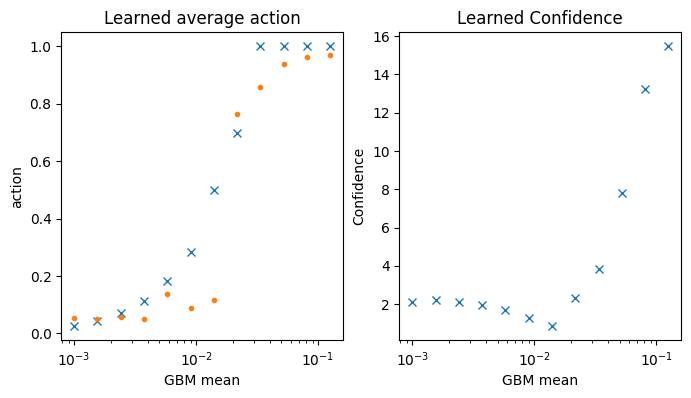

In [19]:
import glob
from agents import ConstantLearner
checkpointFileNames = glob.glob('lightning_logs/constantLearner_biggerUtilSweep/*/*')

models = [ConstantLearner.load_from_checkpoint(ckpFile) for ckpFile in checkpointFileNames]

mus = []
theory = []
learned = []
confidence = []

for model in models:
    mus.append( model.hparams.mu )
    theory.append(  findBestAction_determ(model.hparams.mu, model.hparams.sigma, 1., np.sqrt).x[0] )
    learned.append( model.actionStatistics( torch.tensor([0.5, 0.5, 9.]))[0].item() )
    confidence.append( model.forward( torch.tensor([0.5, 0.5, 9.])).sum().item() )


    
figsize(8, 4)
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.semilogx(mus, theory, 'x')
plt.semilogx(mus, learned, '.')
plt.xlabel('GBM mean')
plt.ylabel('action')
plt.title('Learned average action')

plt.subplot(1,2,2)
plt.semilogx(mus, confidence,'x')
plt.xlabel('GBM mean')
plt.ylabel('Confidence')
plt.title('Learned Confidence')

This looks about the same as previously, possibly a little worse. Overall, I don't think scaling the utility function helps. 

 - It still struggles when the optimal actions are in the mid-ranges.
 
 - Nicely, the confidence (a proxy for how concentrated the distribution is) aligns with the accuracy slump in the middle of the range.



In [35]:
import wandb
wandbapi = wandb.Api()

wandbapi.sweep('lrast/portfolioRL/yyltsfau')

<Sweep lrast/portfolioRL/yyltsfau (FINISHED)>

Looking at the learning curves, we can also see that the certainty has not plateaued by any means in any of the conditions. It is still actively being learned.

### This raises the idea of using certainty as a stopping condition.

1. We know that, in the non-adversarial setting, the optimal policy should be deterministic.
2. Additionally, once the policy get sufficiently concentrated, there is little chance of it changing, as it is sampling mostly from a constant policy anyway.

This seems like a reasonable stopping condition for REINFORCE in a deterministic setting.

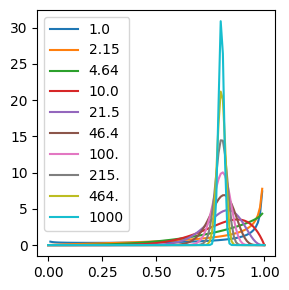

In [53]:
from scipy.stats import beta

xs = np.linspace(0,1, 100)
figsize(3,3)
for confidence in np.logspace(0, 3, 10):
    plt.plot(xs, beta(0.8*confidence, 0.2*confidence).pdf(xs), label=str(confidence)[0:4]  )

plt.tight_layout()
plt.legend()

The distribution isn't really all that concentrated until the confidence is around 100. 20 is too low. High double digits may by enough

In [3]:
wandbapi.run('lrast/portfolioRL/mnaloawq')

<Run lrast/portfolioRL/mnaloawq (running)>

### Even training for a very long time, we don't get the certainty to go that high.

In the above case ^, low mu, I trained for 26k epochs, and only get up to ~10 certainty.

* It's possible that another limiting factor is the number of samples per training epoch: if this is too low (and the variance of returns too high), our samples are noisy and, therefore, never forced to converge to the deterministic policy.

I'll try upping that too.

* Generally, I think scheduling the batch size is probably a good idea for REINFORCE. This is essentially an exploration / exploitation parameter


In [4]:
wandbapi.run('lrast/portfolioRL/32m1w6cn')

<Run lrast/portfolioRL/32m1w6cn (finished)>

### Larger batch size -> higher certainty and nicer learning curves. 

However, it doesn't decrease the need for a large number of training epochs.

Note also that I'm using Adam as a learning rate scheduler. I wonder whether the a simpler learning rate scheduler (or no scheduler at all) combined with batch size scheduling might be help.


### Pilot experiments:

`lrast/portfolioRL/1kowpadb`: batch size scheduling, 100% ground truth

`lrast/portfolioRL/3lqmejt3`: batch size scheduling, ~30% ground truth

`lrast/portfolioRL/bnvnnqzu`: simple SGD

`lrast/portfolioRL/dc3lymyf`: simple SGD: lr$=10^{-6}$


 - Batch size scheduling alone seems to have little effect on certainty learning.
 - Naive SGD suffers from the _opposite_ problem from Adam: the certainty becomes massive after the first epoch, so further learning is extremely difficult. This is promising.
 - Simple learning rate adjustment seems to only delay the problem.
 
### more hyper-parameter fiddling

lr$=10^{-12}$, replicates


`lrast/portfolioRL/1x17ybth`

 - very nice certainty curves. The policy seems to sample well, but doesn't converge to ground truth.
 - In fact, the mean action seems to follow a stochastic trajectory, as new batches come in.
 
`lrast/portfolioRL/1mhpyd5q`, `lrast/portfolioRL/117a1t15`:

 - massive initial certainty
 
`lrast/portfolioRL/1dz0w96a`: lr$=10^{-12}$

 - large certainty jump. Still retains the ability to explore somewhat, but doesn't converge to the ground truth


So, adjusting the learning rate _can_ stochastically solve the certainty learning problem, but this does not always work, where it does there are convergence issues, and it never really finds the ground truth results that we want.

### It's clear to me that this is a hyper-parameter optimization problem.

Looking into existing ideas on training policy gradient algorithms, there are a couple of interesting ideas for variance reduction during learning that may be useful here. 

1. Introducing a discounting factor. For this case, since all of the reward is coming at the end, this is equivalent to scaling the learning rate (generally, down by a lot).

2. Introducing a baseline, either a value function, or a simple estimate of average reward is also supposed to decrease variance.

3. Regularizing the objective function by KL distance between old and new policy. This keeps the policy changes from being too rapid, and is explicitly designed to address the problem that we see here, of early updates trapping the policy. (That said, the mean action is able to change a surprising amount even at high certainty levels)


### While doing some more writing, I found an issue

Namely, that I was using the total loss rather than the mean. This makes the loss explode by a factor of (number of steps) x (batch size).

With that fix, we're back to (overly) slow learning of the parameters. `lrast/portfolioRL/175sdlob`
`lrast/portfolioRL/70deibk1`

I also started tracking the mean utility from runs (which I should have been doing from the beginning). This shows a key difficulty in the learning: the mean utility is noisy and hangs around 1. Since 1 is the utility for 0% allocation to the risky asset, it is not really surprising that learners often fall into this solution. I need a way to decrease the noise. Bigger batch sizes and baselines come to mind. One idea for a baseline is to use the utility if I cash-out now. That is, utility of the current state.

This really seems to stabilize the learning, but it still floats near zero.

In [2]:
from groundTruth import findBestAction_determ, findBestAction

print( findBestAction_determ(0.01, 0.25, 1., np.sqrt).x )
print( findBestAction_determ(0.01*2, 0.25*(2**0.5), 1., np.sqrt).x )
print( findBestAction_determ(0.01*5, 0.25*(5**0.5), 1., np.sqrt).x )
print( findBestAction_determ(0.01*10, 0.25*(10**0.5), 1., np.sqrt).x )

[0.31727411]
[0.31495428]
[0.30712127]
[0.29665147]


Yep, that's right, theres a time effect here that I failed to see when setting up.

## Now I understand what I've been seeing

1. The failure to converge toward deterministic policies for small $\mu$ values was a direct result of the over-simplification of policy representations. By using constant policies, they were no longer able to match the optimal policies, and so remained stochastic. Large $\mu$ values had 100% risky allocation at all times, so they converged just fine. This also explains the consistent _underestimation_ relative to the one-step optimal solution.

2. The baseline is really nice for reducing variance during the learning process. Really indisposable. This is a key take-away.

3. I'm not sure that fiddling with learning rate or batch size scheduling is worthwhile for the moment. The batch size effects were exacerbated by using sums rather than means across batches. This ties batch size into learning rate.




### There is also the issue of the heavy-tailed nature of the distribution

This seems to make learning difficult. For example, even when the average return is large, many of the samples are still loosing money. For a practical learner, the batch size needs to be large to see the mean effect, but simultaneously we know that neural networks learn more slowly for larger batch sizes, so the two effect are in tension with one-another.

REINFORCE scales the learning rate by the reward, so heavy tailed reward distributions are inherited by the learning curves, which become very 'jumpy', changing by large amounts on a small number of trials. See the run below


In [3]:
wandbapi = wandb.Api()
wandbapi.run('lrast/portfolioRL/27alzp0k')

<Run lrast/portfolioRL/27alzp0k (finished)>

- I wonder whether moving to actor-critic and tracking a value function would be useful for alleviating this issue. After all, the value function provides a way to track previously seen situations that are similar to one that we are looking at.

- Could this jumpiness contribute to the failure to converge to high certainty policies? Aren't there convergence guarantees for policy gradient methods?